# Simon's Algorithm

**Abstract:** We study a quantum algorithm known as Simon's algorithm, which provided the first example of an exponential speedup over the best known classical algorithm by using a quantum computer to solve a particular problem. Originally published in 1994, Simon's algorithm was a precursor to Shor's well-known factoring algorithm, and it served as inspiration for many of the seminal works in quantum computation that followed.  

This notebook is aimed at users with some basic knowledge of quantum computing and quantum circuits.

### Table of Contents
* [Simon's Problem Statement](#statement)
 * [Example for n=3](#example)
* [Classical Complexity](#classicalcomplexity)
* [Quantum Algorithm for Simon's Problem](#quantumalgorithm)
 * [Quantum Circuit](#circuit)
 * [Running Simon's Algorithm](#runningintro)
 * [Classical Post-Processing](#postprocessintro)
* [Quantum Complexity](#quantumcomplexity)
* [Implementing Simon's Algorithm in Amazon Braket](#implementation)
* [References](#references)
* [Appendix](#appendix)
 * [Implementing an Oracle Function](#oracleimplementation)
 * [Implementing the Classical Post-Processing](#appendixpostprocessing)

## Simon's Problem Statement: <a name="statement"></a>

Suppose we’re given a function $f:\{0,1\}^n \rightarrow \{0,1\}^n$ that maps bit strings to bit strings along with the promise that
$$\forall x,y \in \{0,1\}^n, \quad f(x) = f(y) \iff x=y\oplus s,$$
for some unknown $n$-bit string $s \in \{0,1\}^n$, and where $\oplus$ means bitwise addition modulo 2.

Said another way, there exists an unknown string $s$ such that, $\forall x, \; f(x)=f(x\oplus s)$. When $s$ is non-zero, the function is two-to-one as it maps *exactly* two inputs to every unique output.

The goal of Simon's problem is to determine if $f$ is one-to-one, or two-to-one, or equivalently to find the secret string $s$.

Since we're given the promise that $f(x)=f(y)\implies x=y\oplus s$, this means that $s=x\oplus y$ whenever $f(x)=f(y)$. Thus, one way to solve this problem is to find two inputs to the function $f$ that produce the *same* output; $s$ is then the XOR of those two input strings. See [[1]](#References) for more details.

<div class="alert alert-block alert-info"><a name="example"></a>
<h3>Example for n=3:</h3>

Consider the function $f:\{0,1\}^3\to\{0,1\}^3$ defined by the truth table below.  
<table>
    <thead>
        <tr>
            <th><center>$$x$$</center></th>
            <th><center>$$f(x)$$</center></th>
        </tr>
    </thead>
    <tr>
        <td><center>$$000$$</center></td>
        <td><center>$$000$$</center></td>
    </tr>
    <tr>
        <td><center>$$001$$</center></td>
        <td><center>$$001$$</center></td>
    </tr>
    <tr>
        <td><center>$$010$$</center></td>
        <td><center>$$001$$</center></td>
    </tr>
    <tr>
        <td><center>$$011$$</center></td>
        <td><center>$$000$$</center></td>
    </tr>
    <tr>
        <td><center>$$100$$</center></td>
        <td><center>$$100$$</center></td>
    </tr>
    <tr>
        <td><center>$$101$$</center></td>
        <td><center>$$101$$</center></td>
    </tr>
    <tr>
        <td><center>$$110$$</center></td>
        <td><center>$$101$$</center></td>
    </tr>
    <tr>
        <td><center>$$111$$</center></td>
        <td><center>$$100$$</center></td>
    </tr>
</table>

    
    
By inspection, we can see that $f$ satisfies the properties described in the statement of Simon's problem. In particular, note that each output $f(x)$ appears twice for two distinct inputs. We are given the promise that, for each of these two inputs $x$ and $y$ with the same output $f(x)=f(y)$, we have $x \oplus s = y$ for a yet to be determined $s$, and therefore $x\oplus y = s$.

For concreteness, notice that the input strings $001$ and $010$ are both mapped by $f$ to the same output string $001$. Taking the bitwise XOR of $001$ and $010$ we obtain the secret string $s$:

$$s=001 \oplus 010 = 011$$

Therefore, in this example, the secret string is $s = 011$.
    
    
In this specific example, we also see that the string $000$ is mapped to itself. Since $x\oplus y=s$ for two inputs $x$ and $y$ with the same output, we must have that $s$ is also mapped to $000$, since $s=000\oplus s$. Indeed, we see that $011$ maps to $000$, as expected.
</div>


## Classical Complexity<a name="classicalcomplexity"></a>

To solve Simon's problem classically, one needs to find two different inputs $x$ and $y$ for which $f(x)=f(y)$. As we saw above, one can then determine $s=x\oplus y$. How hard is it to find two distinct inputs that map to the same output, given the function $f$ as a black box?  For $n$-bit strings, there are $2^n$ possible inputs. Thus, in the worst case, one would need to check at most $2^n$ different inputs to find a pair that maps to the same output; this provides an upper bound on the required query complexity.

It turns out that a *lower* bound on the classical query complexity of Simon's algorithm can also be found: $\Omega ({\sqrt {2^{n}}})$. Proving this lower bound requires a little more work and is outside the scope of this notebook, so instead we will just provide some intuition.

As mentioned above, the goal is to find a pair of input strings $x$ and $y$ that map to the *same* output string $f(x)=f(y)$ -- a collision. Finding a collision in a set is an instance of the well-known (generalized) birthday problem [[2]](#References): within a group of people, what is the probability that two of them share the same birthday? One can turn this problem around and ask "how many people do we need in a room to ensure that the probability that at least two of them share a birthday is greater than some fixed number?" This latter question gets to the heart of solving Simon's problem classically: how many queries to the function $f$ do we need to make to guarantee that we find a collision, with high probability? In the case of the birthday problem, we would need enough people in the room so that when we generate all possible pairings of people, we would have about 365 possible pairs. That way, we'd have a good chance that at least one of those pairs of people share a birthday. Using this intuition, we need to query $f$ enough times to generate a set of *pairs* with roughly the same size as the number of possible inputs ($2^n$). If we make $k$ queries to the function $f$, we can generate ${k \choose 2}=\frac{k(k-1)}{2}\sim k^2$ pairs. Thus, we need to make $k$ queries such that ${k\choose 2}\gtrsim 2^n$ to have a high probability of generating a collision, and therefore, $k>\Omega(\sqrt{2^n})$.

## Quantum Algorithm for Simon's Problem<a name="quantumalgorithm"></a>

Simon's algorithm is a scheme for solving the problem above using exponentially fewer queries to the function $f$. In order for Simon's algorithm to work, one needs to be able to implement the unknown function $f$ using quantum logic. That is, given an input *quantum state* $|x\rangle$, one needs a *unitary* $U_f$ satisfying
$$U_f|x\rangle |0\rangle = |x\rangle |f(x)\rangle.$$
This unitary is an *oracle* for $f$, and the goal is to query it as few times as possible to learn the secret string $s$.

### Quantum Circuit<a name="circuit"></a>

Simon's algorithm involves both quantum and classical components. The quantum part of Simon's algorithm is used to query the oracle efficiently, while the classical component is used to process measurement results and determine the hidden string $s$. A circuit for the quantum component of Simon's algorithm is shown below.
<div align="center">
<img src="quantum_circuit.png", width=500>
</div>

For a function $f$ acting on $n$-bit strings, the circuit above acts on $2n$ qubits, as needed for the definition of $U_f$. Only the first $n$ qubits are measured; the remaining qubits are unused after the application of $U_f$.

### Running Simon's Algorithm<a name="runningintro"></a>
To solve Simon's problem, one needs to run the quantum circuit above several times. After each run of the circuit, the measurements of the first $n$ qubits produce an output bit string, which we denote by $z$.

An analysis of the circuit above shows that each output bit string $z$ satisfies the following condition:
$$ z\cdot s = 0 \; \mod{2}.$$

Let us now analyze the above circuit step-by-step:
1. Initialize all qubits in the $|0\rangle$ state. That is, we start in the state $|0\rangle^{\otimes n} \otimes |0\rangle^{\otimes n}$. We will use the shorthand $|0\rangle^{\otimes n}\equiv |0^n\rangle$
2. Apply Hadamard gates to each of the first $n$ qubits, placing them in the equal superposition state: $$\frac{1}{\sqrt{2^n}}\sum_{x \in \{0, 1\}^n} |x\rangle |0^n\rangle$$.
3. Apply the oracle $U_f$, which computes the function $f$ into the last $n$ qubits, giving the state $$\frac{1}{\sqrt{2^n}}\sum_{x \in \{0, 1\}^n} |x\rangle |f(x)\rangle$$
4. Measure the last $n$ qubits, giving a random result $f(x)$. If $f$ is one-to-one, this output of $f$ corresponds to an input of $x$. If $f$ is two-to-one, the output of $f$ corresponds to an input of either either $x$ or $y = x \oplus s$, where $x$ and $y$ are the two different inputs to $f$ that gave the *same* output $f(x)=f(y)$. Hence we are left with the first $n$ qubits in the state;
    <center>A. $|x\rangle$, &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp; if $f$ is one-to-one;</center>
    <center>B. $\frac{1}{\sqrt{2}} (|x\rangle + |y\rangle)$, where $x \oplus y = s$,&emsp; if $f$ is two-to-one.</center> 
    Note that this step is not strictly necessary, since we do not need the measurement result, but we include it as it makes the analysis easier.
5. Apply Hadamard gates to each of the first $n$ qubits. If $f$ is one-to-one, the state $|x\rangle$ is mapped to $$H^{\otimes n} |x\rangle = \frac{1}{\sqrt{2^n}} \sum_{z \in \{0, 1\}^n} (-1)^{x \cdot z}|z\rangle,$$
   where $x\cdot z$ is the dot product between the two strings represented as vectors (modulo 2).
   
   Similarly, if $f$ is two-to-one, the state $\frac{1}{\sqrt{2}}(|x\rangle + |y\rangle)$ is mapped to $$\frac{1}{\sqrt{2^{n+1}}} \sum_{z \in \{0, 1\}^n} [(-1)^{x \cdot z} + (-1)^{y \cdot z}]|z\rangle$$.
6. Measure the first $n$ qubits.
   1. If $f$ is one-to-one, measurements return a random bit string $z$ uniformly chosen from $\{0,1\}^n$.
   2. If $f$ is two-to-one, measurements return a random bit string $z$ such that $x \cdot z = y \cdot z \,\mathrm{mod}\, 2$, since otherwise the amplitude $(-1)^{x \cdot z} + (-1)^{y \cdot z}$ cancels out. Using the criterion for Simons problem (i.e,. $f(x)=f(y) \implies x=y\oplus s$), we find that
\begin{align*}
x\cdot z &= y\cdot z & \mod{2}\\
x\cdot z &= (x\oplus s)\cdot z &  \mod{2}\\
x\cdot z &= x\cdot z\oplus s\cdot z & \mod{2}\\
0 &= s\cdot z &  \mod{2}
\end{align*}
   
   
   Thus, in both cases we obtain a random bit string $z$ such that $s \cdot z = 0$.

Therefore, each time we run the quantum circuit above, we find a bit string $z$ that is orthogonal to the secret string $s$. 

### Classical Post-Processing<a name="postprocessintro"></a>
From the measurement results $\{z_1, \dots, z_k\}$, we can form a system of equations:
$$ \begin{aligned}z_{1}\cdot s&=0\mod{2}\\z_{2}\cdot s&=0\mod{2}\\&\,\,\vdots \\z_{k}\cdot s&=0\mod{2}\end{aligned}$$ 

There are $k$ equations and $n$ unknowns (the elements of $s$). If we run the quantum part enough times so that we find $n$ **independent** equations, then we can solve these equations (using, e.g., Gaussian elimination) to recover the secret string $s$. This is precisely the classical post-processing required: solve the system of equations found above to recover the string $s$. We refer the interested reader to the [Appendix](#Classical-post-processing) for details.
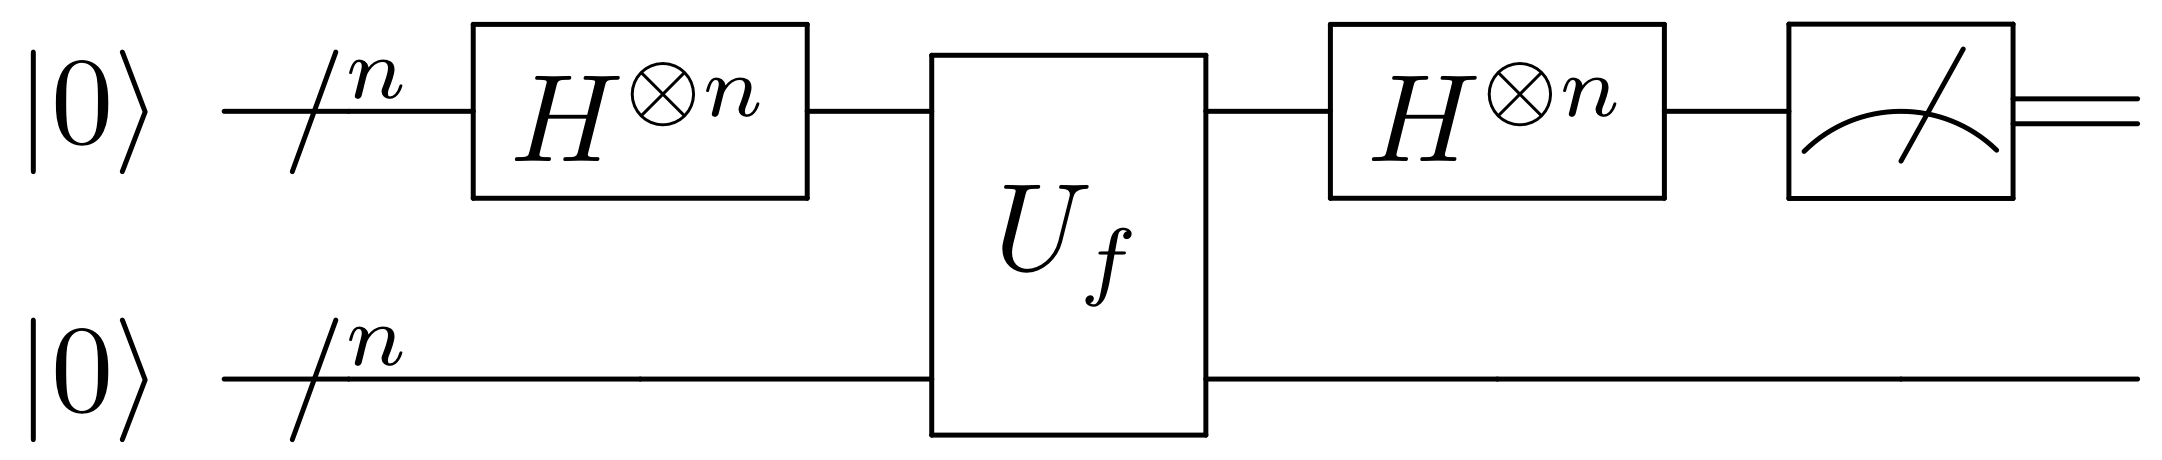

## Quantum Complexity<a name="quantumcomplexity"></a>
How many queries do we need to make to $U_f$ in the quantum case? Above we saw that we need to run the quantum part of the algorithm $k$ times to generate a system of equations. We need to find $n$ linearly independent equations for the system to be determined. Thus, we need at least $n$ queries to $U_f$ to find such a system. It is possible, however, that we will get the same measurement outcome on different runs of the quantum algorithm, so we would need to re-do those runs that do not produce distinct measurement outcomes. Fortunately, these repeated outcomes are unlikely, so we only need $O(n)$ queries to the oracle $U_f$.

Comparing the quantum and classical algorithms, we saw that the classical algorithm requires at least $\Omega(2^{0.5 n})$ queries to $f$, whereas the quantum algorithm requires only $O(n)$. Thus, we have established an *exponential* speedup by using the quantum algorithm above.

# Implementing Simon's Algorithm in Amazon Braket<a name="implementation"></a>

In [1]:
# Imports and Setup
from braket.circuits import Circuit, circuit
from braket.devices import LocalSimulator
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

# Sets the device to run the circuit on
device = LocalSimulator()

We also import a method called `simons_oracle`, which generates a circuit implementing an example oracle function. The code for `simons_oracle` is defined in the `simons_utils.py` module, and it is shown in the [Appendix](#Implementing-an-oracle-function) for completeness. 

In [2]:
# Import local utils
from simons_utils import simons_oracle

We now define the secret string, $s$:

In [3]:
s = '101011'

# Other examples to try:
# s = '011'
# s = '00000'
# s = '1'
# Generate a random string of random length from 1 to 10:
# s="".join(str(np.random.randint(2)) for _ in range(np.random.randint(1,10)))

print("The secret string is: " + s)

The secret string is: 101011


### Circuit Definition

We now define the quantum circuit for Simon's algorithm:
1. Apply Hadamard gates to the first $n$-qubits. 


2. Query the oracle (i.e., the $U_f$ gate). In this example, the oracle is defined dynamically, based on our chosen value of $s$. You can try experimenting with different values of $s$ (with differing lengths).


3. Apply Hadamard gates to the first $n$-qubits.


In [4]:
n = len(s)

circ = Circuit()

# Apply Hadamard gates to first n qubits
circ.h(range(n))

# Now apply the Oracle for f
circ.simons_oracle(s)

# Apply Hadamard gates to the first n qubits
circ.h(range(n))


print(circ)

T   : |0|     1     | 2 |3|4|5|6|
                                 
q0  : -H-C-----------C---C-C-C-H-
         |           |   | | |   
q1  : -H-|-C---------|-H-|-|-|---
         | |         |   | | |   
q2  : -H-|-|-C-------|-H-|-|-|---
         | | |       |   | | |   
q3  : -H-|-|-|-C-----|-H-|-|-|---
         | | | |     |   | | |   
q4  : -H-|-|-|-|-C---|-H-|-|-|---
         | | | | |   |   | | |   
q5  : -H-|-|-|-|-|-C-|-H-|-|-|---
         | | | | | | |   | | |   
q6  : ---X-|-|-|-|-|-X---|-|-|---
           | | | | |     | | |   
q7  : -----X-|-|-|-|-----|-|-|---
             | | | |     | | |   
q8  : -------X-|-|-|-----X-|-|---
               | | |       | |   
q9  : ---------X-|-|-------|-|---
                 | |       | |   
q10 : -----------X-|-------X-|---
                   |         |   
q11 : -------------X---------X---

T   : |0|     1     | 2 |3|4|5|6|


### Now run the circuit

We need enough shots to obtain $n$ linearly independent bit strings in the output measurements. We have chosen `4n` shots in the example below, just to be on the safe side.

In [5]:
task = device.run(circ, shots=4 * n)

### Analyze the results

We can retrieve the measurement results on all $2n$ qubits as follows:

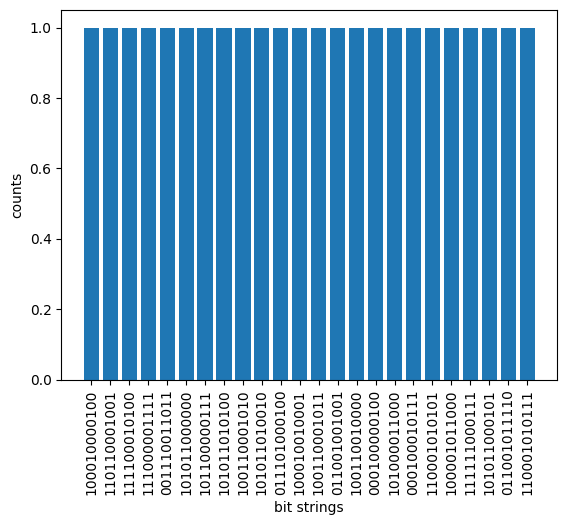

In [6]:
result = task.result()

counts = result.measurement_counts
plt.bar(counts.keys(), counts.values())
plt.xlabel('bit strings')
plt.ylabel('counts')
plt.xticks(rotation=90)
plt.show()

#### Aggregate the results

The measurements are performed on all $2n$ qubits, but we are only interested in the first $n$ qubits. Thus, we need to aggregate the results by ignoring the measurement outcomes on the last $n$ qubits:

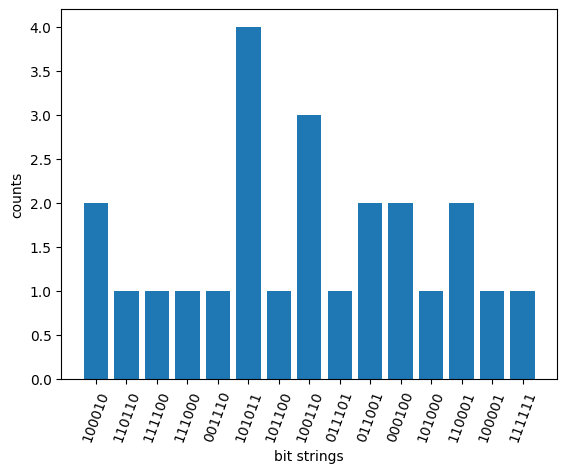

In [7]:
new_results = {}
for bitstring, count in result.measurement_counts.items():
    # Only keep the outcomes on first n qubits
    trunc_bitstring = bitstring[:n]
    # Add the count to that of the of truncated bit string
    new_results[trunc_bitstring] = new_results.get(trunc_bitstring, 0) + count

plt.bar(new_results.keys(), new_results.values())
plt.xlabel('bit strings')
plt.ylabel('counts')
plt.xticks(rotation=70)
plt.show()

In practice, we only need the measurement results (i.e., the bit strings, not the counts) from the first $n$ qubits. These measurement outcomes correspond to bit strings that satisfy the equations:
$$ \begin{aligned}z_{1}\cdot s&=0\mod{2}\\z_{2}\cdot s&=0\mod{2}\\&\,\,\vdots \\z_n\cdot s&=0\mod{2}\end{aligned}$$ 

With these $n$ linear equations in hand, we can use classical post-processing to solve for the unknown string $s$.

Note that we may have too many bit strings in the above, since we ran the quantum task with $2n$ shots just to be safe. In this case, not all of the bit strings will be linearly independent. Moreover, the all-zeros string $0\dots0$ may also be an outcome, but this bit string satisfies the equations above trivially, so we exclude it if needed.

At this stage, the quantum portion of Simon's algorithm is complete. Any remaining steps are just classical postprocessing, which we cover in the Appendix.

### References<a name="references"></a>
[1] Wikipedia: [Simon's Problem](https://en.wikipedia.org/wiki/Simon%27s_problem)

[2] Wikipedia: [Birthday Problem](https://en.wikipedia.org/wiki/Birthday_problem)

[3] Wikipedia: [Computing a kernel by Gaussian elimination](https://en.wikipedia.org/wiki/Kernel_(linear_algebra)#Computation_by_Gaussian_elimination)

[4] StackExchange: [Sympy: Solving Matrices in a finite field](https://stackoverflow.com/questions/31190182/sympy-solving-matrices-in-a-finite-field)

---

## Appendix<a name="appendix"></a>

### Implementing an Oracle Function<a name="oracleimplementation"></a>

In order to run the algorithm, we will need a unitary function that we can use as an oracle to query the function $f$.

There are many possible ways of implementing a function with the desired property that $f(x)=f(y) \implies x=y\oplus s$. We will pick one implementation that is commonly used in example code, and we will try to give some intuition for why this oracle works.

#### Classical Intuition Behind the Function $f$
Generating a function that is one-to-one is conceptually straightforward, as any such function of the bit strings $\{0,1\}^n$ will just be a permutation of the inputs. Generating a two-to-one function is a little trickier, though there are many ways to do it. The goal is to define a function that splits the inputs into two groups, such that one element from each group maps to the same output (i.e., $x$ must be in one group, while $x\oplus s$ must be in the other group.)

We will implement one simple choice for $f$, in which we define the split based on the value of one of the bits in the string. In this way, exactly half of the inputs will have that bit with value $0$, while the other half will have that bit with value $1$. 

Our approach will be to choose a flag bit in the input bit strings that we will use to split the inputs. We then $\mathrm{XOR}$ the input string with $s$ whenever the flag bit is $1$. With this definition, half of the input strings will be untouched, while half of the strings will be $\mathrm{XOR}$'ed with $s$. Clearly, this function does nothing to the all-zeros string $0\dots 0$, since any choice of the flag bit will always be $0$. Thus, we need to ensure that our definition also maps the string $s$ to the all-zeros string $0\dots 0$. In other words, we need to ensure that our flag bit is $1$ when the input string is $s$. One way to ensure the function acts correctly on the input $s$ is to just define the flag bit to be the first bit in the string $s$ that is equal to $1$. For example, if $s=011$, we can choose the flag bit to be the second bit. Concretely:
$$f(x) = \left\{\begin{array}{lr}
x, & \text{if } x_j=0\\
x\oplus s, & \text{if } x_j=1\\
\end{array}\right\},$$
where $x_j$ is the $j^\text{th}$ bit of $x$, and $j$ is the flag bit in $s$.

<div class="alert alert-block alert-info">
    <h4>Example for n=3:</h4>

We now revisit the example in the introduction. Suppose the secret string $s=011$. Since the first appearance of $1$ in $s$ occurs at the second bit, we will use the second bit in the input strings as our flag bit. We take the $\mathrm{XOR}$ of the input with $s$ whenever the flag bit in the input is 1. This definition results in the following truth table:   

<table>
    <thead>
        <tr>
            <th><center>$$x$$</center></th>
            <th><center>$$f(x)$$</center></th>
        </tr>
    </thead>
    <tr>
        <td><center>$$000$$</center></td>
        <td><center>$$000$$</center></td>
    </tr>
    <tr>
        <td><center>$$001$$</center></td>
        <td><center>$$001$$</center></td>
    </tr>
    <tr>
        <td><center>$$010$$</center></td>
        <td><center>$$001$$</center></td>
    </tr>
    <tr>
        <td><center>$$011$$</center></td>
        <td><center>$$000$$</center></td>
    </tr>
    <tr>
        <td><center>$$100$$</center></td>
        <td><center>$$100$$</center></td>
    </tr>
    <tr>
        <td><center>$$101$$</center></td>
        <td><center>$$101$$</center></td>
    </tr>
    <tr>
        <td><center>$$110$$</center></td>
        <td><center>$$101$$</center></td>
    </tr>
    <tr>
        <td><center>$$111$$</center></td>
        <td><center>$$100$$</center></td>
    </tr>
</table>
</div>

We leave it as an exercise to the reader to verify that this definition works for any input string size (i.e., $n$ for inputs $\{0,1\}^n$, and that it is in fact two-to-one, rather than many-to-one. Note that the function defined in this way is not a general two-to-one function, but it is simple a choice that is easy to implement both classically and as a quantum circuit.

#### Quantum Implementation of $U_f$
We now define the unitary using the `@circuit.subroutine` functionality of the Amazon Braket SDK. The following code was imported from the `simons_utils.py` module, and is shown below for reference. 

In the quantum setting, we first copy the input register into some ancillary qubits:
$$ |x\rangle|0\rangle\mapsto |x\rangle|x\rangle.$$
We then perform the quantum analog of $\mathrm{XOR}$, which means we apply an $X$ gate to the $k^\text{th}$ qubit whenever the $k^\text{th}$ bit of $s$ is $1$. However, we only apply this $X$ gate when the flag qubit is also $|1\rangle$. Thus, our $X$ gate becomes a $\mathrm{CNOT}$ gate between the flag qubit on the input register, and the $k^\text{th}$ qubit on the output.

```python
from braket.circuits import Circuit, circuit

@circuit.subroutine(register=True)
def simons_oracle(secret_s: str):
    """
    Quantum circuit implementing a particular oracle for Simon's problem. Details of this implementation are
    explained in the Simons Algorithm demo notebook.

    Args:
        secret_s (str): secret string we wish to find
    """
    # Find the index of the first 1 in s, to be used as the flag bit
    flag_bit=secret_s.find('1')
    
    n=len(secret_s)
    
    circ = Circuit()
    # First copy the first n qubits, so that |x>|0> -> |x>|x>
    for i in range(n):
        circ.cnot(i, i+n)
    
    # If flag_bit=-1, s is the all-zeros string, and we do nothing else.
    if flag_bit != -1:
        # Now apply the XOR with s whenever the flag bit is 1.
        for index,bit_value in enumerate(secret_s):
            
            if bit_value not in ['0','1']:
                raise Exception ('Incorrect char \'' + bit_value + '\' in secret string s:' + secret_s)
                
            # XOR with s whenever the flag bit is 1.
            # In terms of gates, XOR means we apply an X gate only whenever the corresponding bit in s is 1.
            # Applying this X only when the flag qubit is 1 means this is a CNOT gate.
            if(bit_value == '1'):
                circ.cnot(flag_bit,index+n)
    return circ
```

### Implementing the Classical Post-Processing<a name="appendixpostprocessing"></a>

We will now solve the system of linear equations above using Gaussian elimination. We first convert the results into matrix form, then we use `sympy`'s `Matrix.rref()` method to transform the matrix into reduced row echelon form. 

In [8]:
from sympy import Matrix


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


Generate a matrix from the bit string outputs. We first check that we have sufficiently many output strings to be able to solve the system of equations. If not: output and error and re-run the algorithm.

In [9]:
if len(new_results.keys()) < len(s):
    raise Exception(
        'System will be underdetermined. Minimum '
        + str(n)
        + ' bistrings needed, but only '
        + str(len(new_results.keys()))
        + ' returned. Please rerun Simon\'s algorithm.'
    )
string_list = []

for key in new_results.keys():
    #     if key!= "0"*n:
    string_list.append([int(c) for c in key])

print('The result in matrix form is :')
for a in string_list:
    print(a)

The result in matrix form is :
[1, 0, 0, 0, 1, 0]
[1, 1, 0, 1, 1, 0]
[1, 1, 1, 1, 0, 0]
[1, 1, 1, 0, 0, 0]
[0, 0, 1, 1, 1, 0]
[1, 0, 1, 0, 1, 1]
[1, 0, 1, 1, 0, 0]
[1, 0, 0, 1, 1, 0]
[0, 1, 1, 1, 0, 1]
[0, 1, 1, 0, 0, 1]
[0, 0, 0, 1, 0, 0]
[1, 0, 1, 0, 0, 0]
[1, 1, 0, 0, 0, 1]
[1, 0, 0, 0, 0, 1]
[1, 1, 1, 1, 1, 1]


Now solve the system $Ms=0$ by finding the kernel of $M$. We do this using Gaussian elimination on the augmented matrix $\left[A|I\right]$ to bring it to row echelon form. Converting the solution to numbers $\mathrm{mod }\,2$, we can then read off the solution from the last row of the reduced matrix. See [[3]](#References) and [[4]](#References) for more details.

In [10]:
M = Matrix(string_list).T

# Construct the agumented matrix
M_I = Matrix(np.hstack([M, np.eye(M.shape[0], dtype=int)]))

# Perform row reduction, working modulo 2. We use the iszerofunc property of rref
# to perform the Gaussian elimination over the finite field.
M_I_rref = M_I.rref(iszerofunc=lambda x: x % 2 == 0)

# In row reduced echelon form, we can end up with a solution outside of the finite field {0,1}.
# Thus, we need to revert the matrix back to this field by treating fractions as a modular inverse.
# Since the denominator will always be odd (i.e. 1 mod 2), it can be ignored.


# Helper function to treat fractions as modular inverse:
def mod2(x):
    return x.as_numer_denom()[0] % 2


# Apply our helper function to the matrix
M_I_final = M_I_rref[0].applyfunc(mod2)

# Extract the kernel of M from the remaining columns of the last row, when s is nonzero.
if all(value == 0 for value in M_I_final[-1, : M.shape[1]]):
    result_s = "".join(str(c) for c in M_I_final[-1, M.shape[1] :])

# Otherwise, the sub-matrix will be full rank, so just set s=0...0
else:
    result_s = '0' * M.shape[0]

# Check whether result_s is equal to initial s:
print('Secret string: ' + s)
print('Result string: ' + result_s)
if result_s == s:
    print('We found the correct answer.')
else:
    print('Error. The answer is wrong!')

Secret string: 101011
Result string: 101011
We found the correct answer.
